# Importing libraries

In [1]:
import math
import requests 
from bs4 import BeautifulSoup 
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import gmaps
import ipywidgets as widgets
import json
key="Your API Key"
gmaps.configure(api_key=key)

# Importing live dataset

In [2]:
#raw_data_1,raw_data_2,raw_data_3
data=pd.DataFrame(json.loads(requests.get("https://api.covid19india.org/raw_data1.json").content)['raw_data'])
data2=pd.DataFrame(json.loads(requests.get("https://api.covid19india.org/raw_data2.json").content)['raw_data'])
data3=pd.DataFrame(json.loads(requests.get("https://api.covid19india.org/raw_data3.json").content)['raw_data'])
data=data.append(data2)
data=data.drop(columns=['backupnotes','estimatedonsetdate'])
data3=data3.drop(columns=['numcases','entryid'])
data=data.append(data3)
data.reset_index(inplace = True,drop=True)

In [3]:
#Travel history (No more updated)
data_travel_history=pd.DataFrame(json.loads(requests.get("https://api.covid19india.org/travel_history.json").content)["travel_history"])
#State Level : Testing data
data_total_tested=pd.DataFrame(json.loads(requests.get("https://api.covid19india.org/state_test_data.json").content)["states_tested_data"])
data_total_tested=data_total_tested.drop(columns=['numcallsstatehelpline'])

In [4]:
#National Level :1. Time series, 2. State-wise stats and 3. Test counts only. State-wise stats used
data_death_and_recovered=pd.DataFrame(json.loads(requests.get("https://api.covid19india.org/data.json").content)["statewise"])


In [5]:
#State Level : Daily changes
data_daily_cases=pd.DataFrame(json.loads(requests.get("https://api.covid19india.org/states_daily.json").content)["states_daily"])

In [6]:
#State Level : has district-wise info V2 (minor difference in structure)
file=json.loads(requests.get("https://api.covid19india.org/v2/state_district_wise.json").content)
data_district_wise=pd.DataFrame()
for i in range(len(file)):
    data_district_wise=data_district_wise.append(pd.DataFrame(file[i]['districtData']))
data_district_wise=data_district_wise.drop(columns=['delta','notes'])

In [7]:
cols = list(data_daily_cases)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('status')))
cols.insert(1, cols.pop(cols.index('date')))
# use ix to reorder
data_daily_cases = data_daily_cases.loc[:, cols]

In [8]:
#District Level : Zones
data_zones=pd.DataFrame(json.loads(requests.get("https://api.covid19india.org/zones.json").content)["zones"])

Organising Live dataset and converting to respective data *types*

In [9]:
data_death_and_recovered.rename(columns = {'deaths':'deceased'}, inplace = True) 
for columns in ['active', 'confirmed', 'deceased', 'deltaconfirmed', 'deltadeaths','deltarecovered', 'recovered']:
    data_death_and_recovered[columns]=pd.to_numeric(data_death_and_recovered[columns])

In [10]:
data = data[data['patientnumber'].notna()]
data=data.replace("EVACUEES","Evacuees")
data['dateannounced'].replace('', np.nan,inplace=True)
data['dateannounced'] = pd.to_datetime(data['dateannounced'], format="%d/%m/%Y")
for i in range(len(data)):
    if(len(data.loc[i]['agebracket'].split("-"))>1):
        data.at[i,'agebracket']=data.loc[i]['agebracket'].split("-")[1]
data['agebracket']=pd.to_numeric(data['agebracket'])

In [11]:
import warnings
warnings.filterwarnings("ignore")
data_total_tested['numisolationbeds']=[row['numisolationbeds'].replace(",","") for index,row in data_total_tested.iterrows()]
data_total_tested['totalpeopleinquarantine']=[row['totalpeopleinquarantine'].replace(",","") for index,row in data_total_tested.iterrows()]
data_total_tested['numventilators']=[row['numventilators'].replace(",","") for index,row in data_total_tested.iterrows()]
data_total_tested['testpositivityrate']=[row['testpositivityrate'].replace("%","") for index,row in data_total_tested.iterrows()]

data_total_tested['testsperthousand']=pd.to_numeric(data_total_tested['testsperthousand'])
data_total_tested['testspermillion']=pd.to_numeric(data_total_tested['testspermillion'])
data_total_tested['testpositivityrate']=pd.to_numeric(data_total_tested['testpositivityrate'])
data_total_tested['totaltested']=pd.to_numeric(data_total_tested['totaltested'])
data_total_tested = data_total_tested[data_total_tested['totaltested'].notna()]
data_total_tested['positive']=pd.to_numeric(data_total_tested['positive'])
data_total_tested['negative']=pd.to_numeric(data_total_tested['negative'])
data_total_tested['unconfirmed']=pd.to_numeric(data_total_tested['unconfirmed'])
data_total_tested['numisolationbeds']=pd.to_numeric(data_total_tested['numisolationbeds'])
data_total_tested['numicubeds']=pd.to_numeric(data_total_tested['numicubeds'])
data_total_tested['numventilators']=pd.to_numeric(data_total_tested['numventilators'])

In [12]:
for columns in data_daily_cases.columns[2:]:
    data_daily_cases[columns]=pd.to_numeric(data_daily_cases[columns])

# Analysis of data

In [28]:
detected_cases = data.groupby("detectedstate").size()
detected_cases.sort_values(ascending=False)

detectedstate
Maharashtra                    8319
Tamil Nadu                     3649
Gujarat                        3642
Delhi                          2938
Rajasthan                      2435
Madhya Pradesh                 2257
Uttar Pradesh                  2154
Andhra Pradesh                 1706
Telangana                      1029
Karnataka                       810
West Bengal                     681
Jammu and Kashmir               616
Bihar                           564
Kerala                          564
Punjab                          428
Haryana                         374
Odisha                          184
Chandigarh                      104
Jharkhand                       101
                                 71
Uttarakhand                      67
Himachal Pradesh                 53
Chhattisgarh                     50
Assam                            46
Andaman and Nicobar Islands      38
Ladakh                           25
Meghalaya                        15
Puducherry    

# Plots

Population Pyramid for infections

In [29]:
df_age = data[['gender', 'agebracket']].copy()
df_age.replace('', np.nan,inplace=True)
df_age.dropna(how='any', subset=['gender', 'agebracket'],inplace=True)
df_age['age'] = df_age.apply(lambda x : pd.to_numeric((x['agebracket'])),axis=1)

In [30]:
# Putting data into age groups
bins = [x for x in range(0,100,10)]
df_age['age_group'] = pd.cut(df_age['age'], bins=bins)
#print(df_age)

In [31]:
# Convert groupby to dataframe
ndf = pd.DataFrame({'count' : df_age.groupby(['age_group', 'gender']).size()}).reset_index()
# convert count values of females to negative
ndf.loc[ndf.gender == 'F', 'count']=-ndf.loc[ndf.gender == 'F', 'count']
#ndf

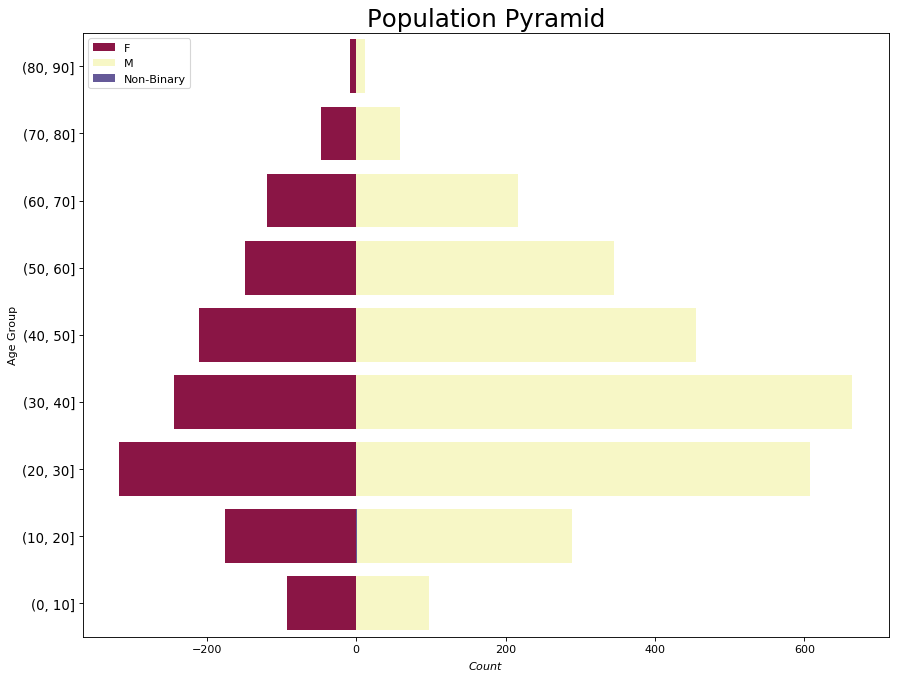

In [32]:
import seaborn as sns

# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
group_col = 'gender'
order_of_bars = ndf['age_group'].unique()[::-1]
colors = [plt.cm.Spectral(i/float(len(ndf[group_col].unique())-1)) for i in range(len(ndf[group_col].unique()))]

#print(colors, ndf[group_col].unique())
for c, group in zip(colors, ndf[group_col].unique()):
    sns.barplot(x='count', y='age_group', data=ndf.loc[ndf[group_col]==group, :], order=order_of_bars, color=c, label=group)

# Decorations    
plt.xlabel("$Count$")
plt.ylabel("Age Group")
plt.yticks(fontsize=12)
plt.title("Population Pyramid", fontsize=22)
plt.legend()
plt.show()

Chart for  total cases per state

In [33]:
threshold=400
data_cases_per_state=data_death_and_recovered[['active','deceased']]
data_cases_per_state['recovered']=data_death_and_recovered['confirmed']-data_death_and_recovered['deceased']-data_death_and_recovered['active']
data_cases_per_state.index=data_death_and_recovered['state']
data_cases_per_state=data_cases_per_state.loc[(data_cases_per_state.sum(axis=1) >threshold)]

In [34]:
import plotly.graph_objects as go
states=data_cases_per_state.index
fig = go.Figure(data=[
    go.Bar(name='active', y=states,x=data_cases_per_state['active'] ,orientation='h'),
    go.Bar(name='deceased', y=states, x=data_cases_per_state['deceased'] ,orientation='h'),
    go.Bar(name='recovered', y=states,x=data_cases_per_state['recovered'] ,orientation='h'),
])
# Change the bar mode
fig.update_layout(title="Total cases per state",width=1000,height=700,barmode='stack')
fig.show()

Chart for type of transmission per state

In [35]:
threshold=20
data_type_of_transmission_per_state=pd.DataFrame(0,columns=['Imported','Local','Unknown'],index=data['detectedstate'].unique())
patient_stats=data.groupby(['detectedstate','typeoftransmission']).size()
for state in data['detectedstate'].unique():
    if state !='' and len(data[data['detectedstate']==state])>threshold: 
        if 'Imported' in patient_stats[state].keys():
            data_type_of_transmission_per_state.loc[state]['Imported']=patient_stats[state]['Imported']
        if 'Local' in patient_stats[state].keys():
            data_type_of_transmission_per_state.loc[state]['Local']=patient_stats[state]['Local']
        if 'TBD' in patient_stats[state].keys():
            data_type_of_transmission_per_state.loc[state]['Unknown']=patient_stats[state]['TBD']
        if '' in patient_stats[state].keys():
            data_type_of_transmission_per_state.loc[state]['Unknown']=data_type_of_transmission_per_state.loc[state]['Unknown']+patient_stats[state][''] 
data_type_of_transmission_per_state=data_type_of_transmission_per_state.loc[(data_type_of_transmission_per_state.sum(axis=1) >threshold)]

In [36]:
import plotly.graph_objects as go
states=data_type_of_transmission_per_state.index
fig = go.Figure(data=[
    go.Bar(name='Imported', y=states,x=data_type_of_transmission_per_state['Imported'] ,orientation='h'),
    go.Bar(name='Local', y=states, x=data_type_of_transmission_per_state['Local'] ,orientation='h'),
    go.Bar(name='Unknown', y=states,x=data_type_of_transmission_per_state['Unknown'] ,orientation='h'),
])
# Change the bar mode
fig.update_layout( title="Type of transmission per state",width=1000,height=700,barmode='stack')
fig.show()

Chart for total testing and percentage

In [37]:
percentage=pd.DataFrame(0,columns=['totaltested','positive','negative','Percentage'],index=[keys for keys in data_total_tested.groupby('state').size().keys()])
for index,rows in data_total_tested.iterrows():
        percentage.loc[rows['state']]['totaltested']=rows['totaltested']
        percentage.loc[rows['state']]['positive']=rows['positive']
        percentage.loc[rows['state']]['negative']=rows['negative']
percentage['Percentage']=percentage['positive']/percentage['totaltested']
percentage.sort_values(by='Percentage',ascending=False)

totaltested  positive  negative  Percentage
Maharashtra                       168374     12974    156078    0.077055
Delhi                              64108      4898     39920    0.076402
Gujarat                            84648      5804     74632    0.068566
Chandigarh                          1678       102      1545    0.060787
Madhya Pradesh                     52095      2942     46634    0.056474
Telangana                          19278      1016     14104    0.052703
West Bengal                        25116      1259       568    0.050127
Punjab                             28545      1232     21295    0.043160
Uttar Pradesh                      98300      2766     94682    0.028138
Jammu and Kashmir                  28199       726     27473    0.025746
Rajasthan                         134987      3127    128297    0.023165
Tamil Nadu                        162970      3550    158558    0.021783
Bihar                              29906       529      2299    0.017689
Ladakh                              2639        41      1879    0.015536
Kerala                             33010       499     32315    0.015117
Haryana                            38183       517     34501    0.013540
Andhra Pradesh                    133492      1717    131775    0.012862
Andaman and Nicobar Islands         3754        33      1210    0.008791
Jharkhand                          13832       115     13717    0.008314
Karnataka                          79193       651     74664    0.008220
Uttarakhand                         8060        61      7357    0.007568
Meghalaya                           1884        12      1782    0.006369
Himachal Pradesh                    7430        41      7320    0.005518
Mizoram                              183         1         0    0.005464
Odisha                             44663       170      9629    0.003806
Puducherry                          3281        12      3220    0.003657
Assam                              12775        42     11764    0.003288
Tripura                             5394        17      5377    0.003152
Chhattisgarh                       19902        57     18848    0.002864
Goa                                 2899         7       197    0.002415
Arunachal Pradesh                    869         2       762    0.002301
Nagaland                             708         0       679    0.000000
Sikkim                               170         0       169    0.000000

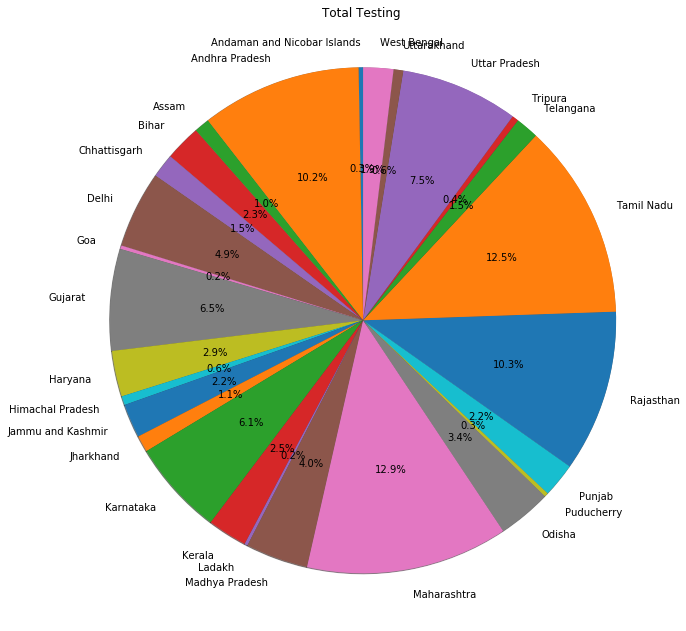

In [38]:
threshold=2500
plt.figure(figsize=(10,11))
labels = percentage[percentage['totaltested']>threshold].index
sizes = percentage[percentage['totaltested']>threshold]['totaltested']
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes,labels=labels, 
autopct='%1.1f%%', textprops={'fontsize': 10},shadow=True,radius=10, startangle=90)
plt.title("Total Testing ")
plt.axis('equal')
plt.show()

Statewise testing trends

In [39]:
column_names=data_total_tested['updatedon'].unique()
column_names=pd.to_datetime(pd.Series(column_names), format="%d/%m/%Y")
column_names=column_names.sort_values(ascending=True)
data_statewise_tests=pd.DataFrame(np.nan,columns=column_names,index=[keys for keys in data_total_tested.groupby('state').size().keys()])
for index,rows in data_total_tested.iterrows():
    data_statewise_tests.loc[rows['state']][rows['updatedon']]=rows['totaltested']


In [40]:
for index,rows in data_statewise_tests.iterrows():
    data_statewise_tests.loc[index]=data_statewise_tests.loc[index].cumsum()

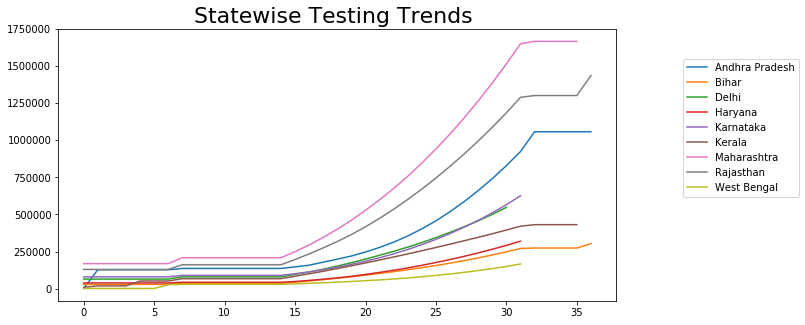

In [41]:
legend=[]
plt.figure(figsize=(10,5))
for index,rows in data_statewise_tests.iterrows():
    if(index in ['Maharashtra','Rajasthan','Delhi','West Bengal','Kerala','Karnataka','Haryana','Bihar','Andhra Pradesh']):
        legend.append(index)
        plt.plot(np.arange(len(rows)),rows.fillna(method='bfill'))
        #print(rows)
plt.legend(legend, bbox_to_anchor=(1.16,0.4), loc="lower right", 
                          bbox_transform=plt.gcf().transFigure)
plt.title("Statewise Testing Trends ", fontsize=22)
plt.show()

Plot of daywise trends of confirmed cases

In [42]:
data_per_state=pd.DataFrame(0,index=data_daily_cases.columns[2:],columns=data_daily_cases['date'].unique())
for date in data_daily_cases['date'].unique():
    data_per_state[date]=data_daily_cases[data_daily_cases['date']==date].iloc[0] #0 for confirmed cases
    
for index,rows in data_per_state.iterrows():
    data_per_state.loc[index]=data_per_state.loc[index].cumsum()
data_per_state=data_per_state[1:]

In [46]:
days=11 #considering starting date for analysis as 10th day since recording covid cases i.e '25-Mar-20' i.e lockdown date
cols=data_per_state.columns[days:]
data_per_state = data_per_state.ix[:, cols]

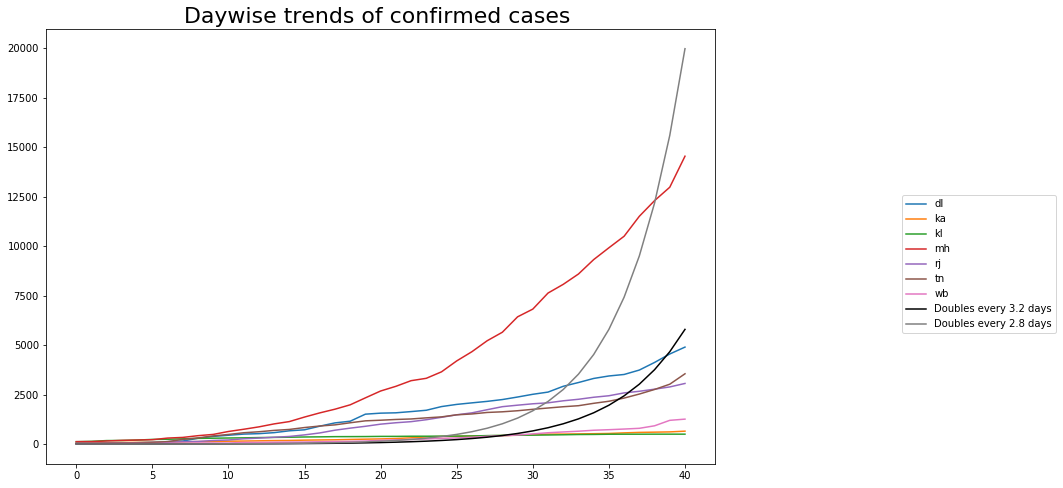

In [52]:
doubling_factor1=3.2 #Upper limit
doubling_factor2=2.8 #lower limit
plt.figure(figsize=(12,8))
legend=[]
for index,rows in data_per_state.iterrows():
    if index in ['mh','dl','wb','kl','rj','ka','tn']:
        legend.append(index)
        plt.plot(np.arange(len(rows)),rows.values)
plt.plot(pow(2,(np.arange(len(rows))/doubling_factor1)),color='black')
legend.append('Doubles every '+str(doubling_factor1)+' days')
plt.plot(pow(2,(np.arange(len(rows))/doubling_factor2)),color='gray')
legend.append('Doubles every '+str(doubling_factor2)+' days')
plt.legend(legend, bbox_to_anchor=(1.3,0.6),bbox_transform=plt.gcf().transFigure)
plt.title("Daywise trends of confirmed cases ", fontsize=22)
plt.show()

Daywise country trends

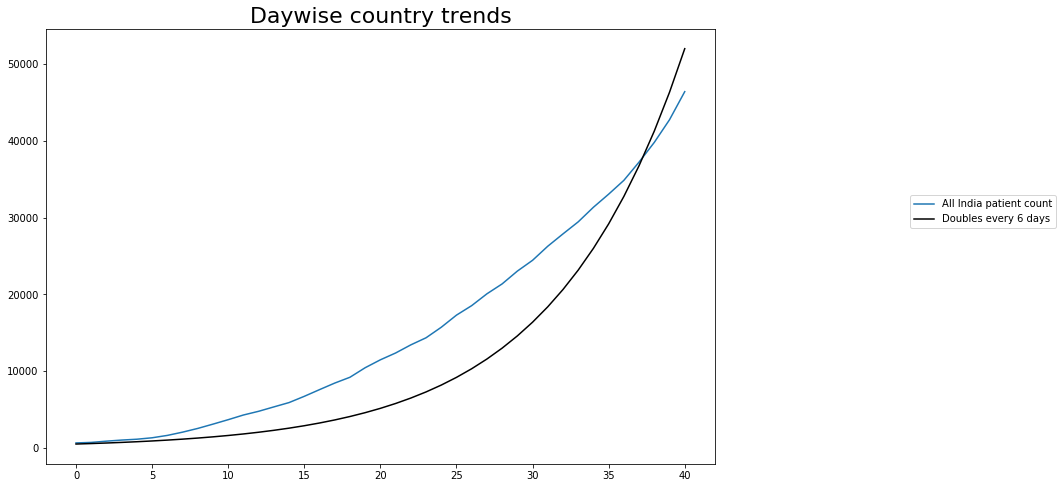

In [53]:
legend=[]
doubling_factor=6 #factor
plt.figure(figsize=(12,8))
initial_val=math.log2(data_per_state.loc['tt'][0])
plt.plot(np.arange(len(data_per_state.loc['tt'])),data_per_state.loc['tt'].values)
legend.append('All India patient count')
plt.plot(pow(2,(np.arange(len(data_per_state.loc['tt']))/doubling_factor)+int(initial_val)),color='black')
legend.append('Doubles every '+str(doubling_factor)+' days')
plt.legend(legend, bbox_to_anchor=(1.3,0.6),bbox_transform=plt.gcf().transFigure)
plt.title("Daywise country trends",fontsize=22)
plt.show()

Average age of corona infected patients

In [54]:
age=data['agebracket']
age=age.dropna()
sum(age)/len(age)

37.57156157427

In [55]:
gender_status = data.groupby(["gender","currentstatus"]).size()
gender_status['F',"Deceased"]/(gender_status['F',"Deceased"]+gender_status['F',"Recovered"])

0.6460176991150443

In [56]:
gender_status[:,"Deceased"]/(gender_status[:,"Deceased"]+gender_status[:,"Recovered"])

gender
     0.159247
F    0.646018
M    0.623894
dtype: float64

# Save in a list, all the cluster of patient



In [97]:
cluster=[]
for index, rows in data.iterrows(): 
    if(len(str(rows['contractedfromwhichpatientsuspected']))>0 and (str(rows['contractedfromwhichpatientsuspected']).startswith("P") or str(rows['contractedfromwhichpatientsuspected']).startswith("E"))):
        contracted_from=rows['contractedfromwhichpatientsuspected'].split(',')
        contracted_from.append("P"+rows['patientnumber'])
        cluster.append(contracted_from)
    else:
        cluster.append(["P"+rows['patientnumber']])

Removing sublists from the entire list

In [109]:
def removeSublist(lst): 
    curr_res = [] 
    result = [] 
    for ele in sorted(map(set, lst), key = len, reverse = True): 
        if not any(ele <= req for req in curr_res): 
            curr_res.append(ele) 
            result.append(list(ele)) 
          
    return result 
      
# Driver code 
cluster=removeSublist(cluster)

Finding all connected components and creating Graph

In [110]:
import networkx as nx 
G=nx.Graph()
for l in cluster:
    nx.add_path(G, l)
connected_components=list(nx.connected_components(G))

Removing all connected components having no. of nodes less than

In [111]:
threshold_lower=10 #lower_limit
threshold_upper=100 #upper_limit
remove=nx.Graph()
for c in nx.connected_components(G):
    if(len(c)<threshold_lower or len(c)>threshold_upper):
        remove.add_nodes_from(c)
    else:
        print(c)
        print(len(c))
G.remove_nodes_from(remove)

{'P49', 'P38', 'P50', 'P57', 'P37', 'P58', 'P555', 'P39', ' P37', ' P38', 'P59', 'P35', ' P36', 'P36', 'P56'}
15
{'P24597', 'P23431', ' P24603', 'P21467', 'P23429', 'P24843', 'P21472', 'P21469', 'P24842', 'P21464', 'P24598', 'P24595', 'P23159', 'P23434', 'P21466', 'P21468', 'P24844', 'P24596', 'P23433', 'P21470', 'P23432', 'P20410', 'P29416', 'P24845', 'P23430', 'P23156', 'P21465', 'P24599', 'P23157', 'P23158', 'P29408', ' P24602', 'P23155', 'P21471'}
34
{'P1187', 'P1176', 'P1182', 'P1079', 'P1078', 'P1186', 'P1185', 'P301', 'P1076', 'P1175', ' P302', 'P1178', 'P1174', 'P1188', 'P1177', 'P750', 'P1180', 'P1181', 'P748', 'P749', 'P502', 'P653', 'P1077', 'P1179', 'P1183', 'P1184', 'P751'}
27
{'P2587', 'P14705', 'P4372', 'P6213', 'P10744', 'P4373', 'P10746', 'P14704', 'P6212', 'P6214', 'P10743', 'P4860'}
12
{'P28464', 'P12596', 'P11592', ' P20415', 'P18790', 'P12590', 'P17895', 'P11591', 'P8460', 'P17903', 'P28469', 'P30605', 'P18795', 'P28468', 'P20416', 'P20415', 'P28929', 'P14715', 'P1

# Plotting Clusters

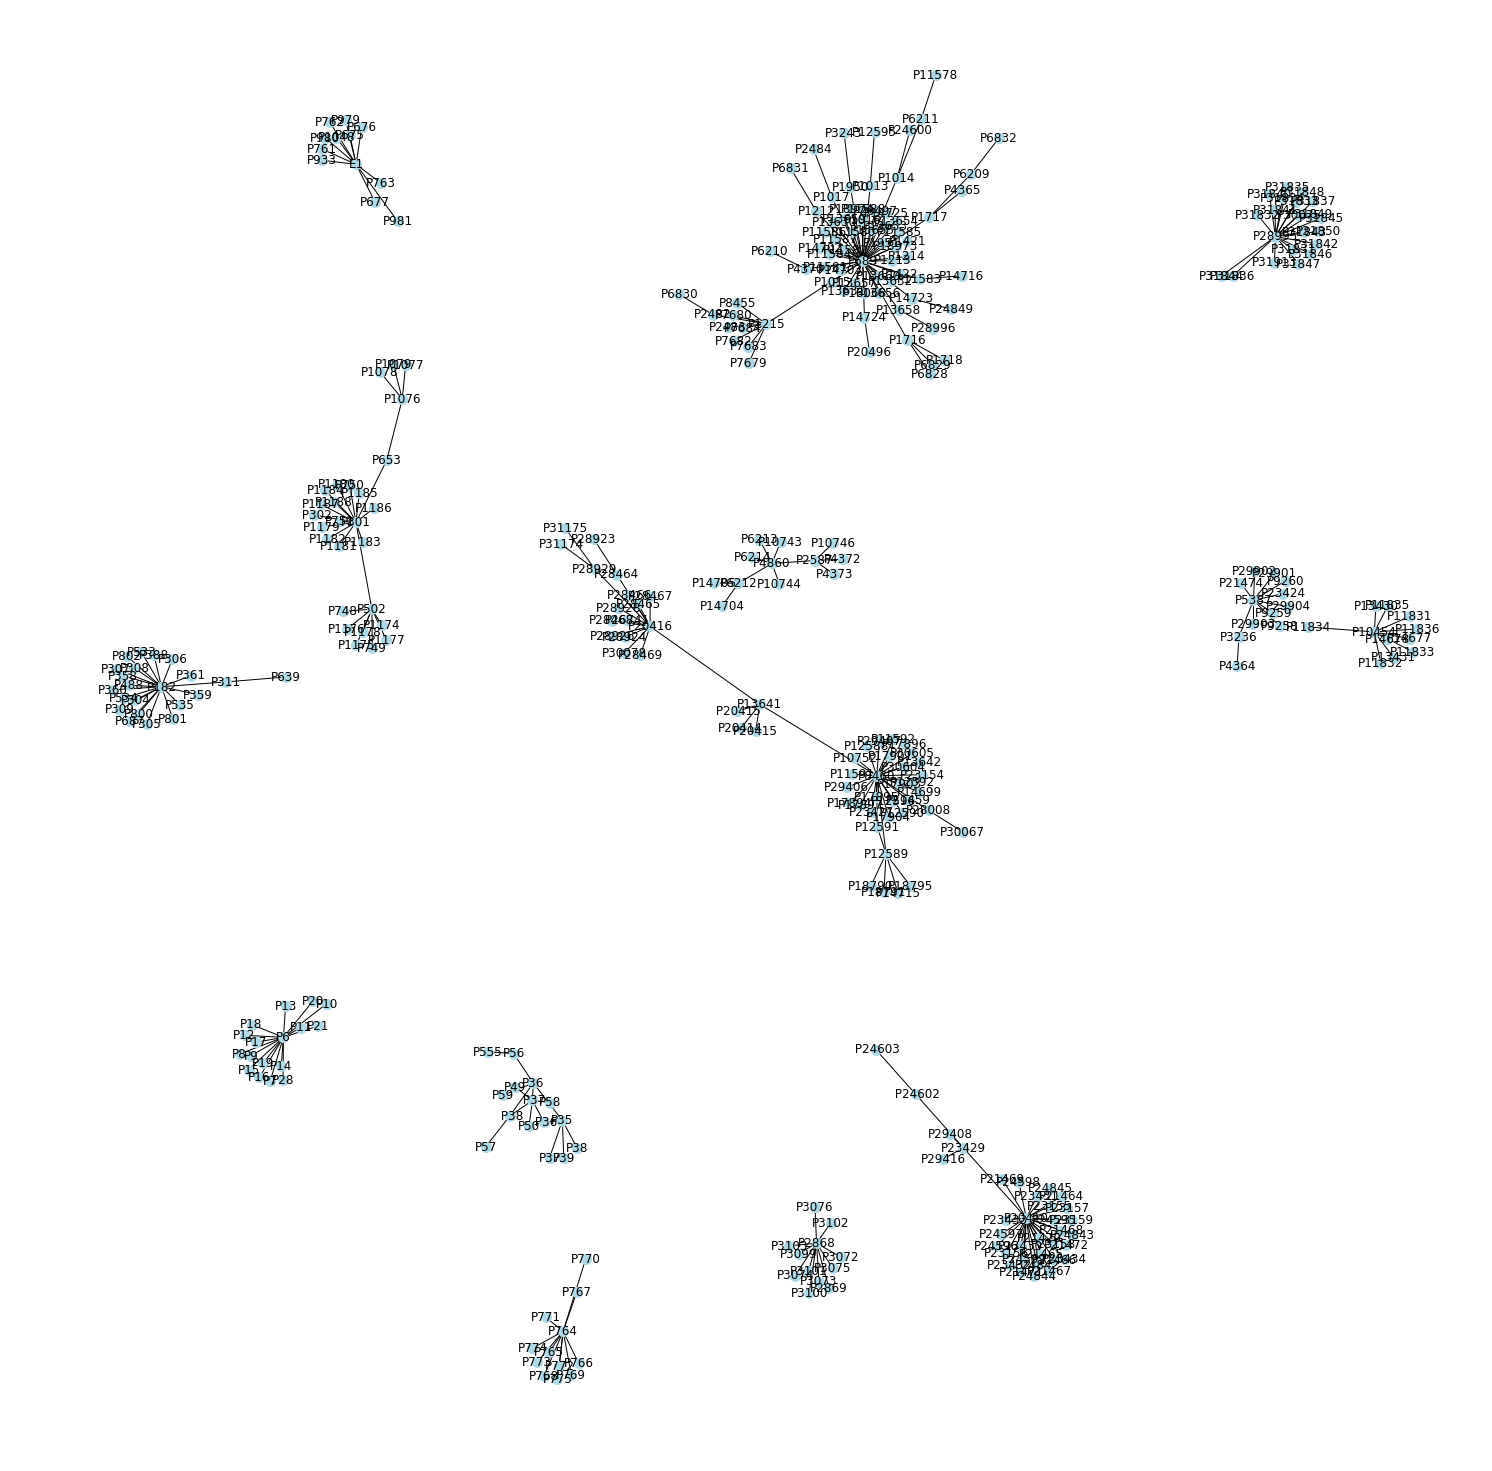

In [113]:
import warnings
warnings.filterwarnings("ignore")
pos = nx.spring_layout(G, scale=1)
plt.figure(3,figsize=(20,20)) 
nx.draw(G, pos, node_color='lightblue', node_size=100, with_labels=True)

# Super Spreaders




In [114]:
super_spreaders=[]
header=['spreading_factor']
header.extend(data.columns.values)
for node in G.nodes:
    if G.degree(node)>2 and node.startswith('P'):
        l=[G.degree(node)]
        l.extend(data[data['patientnumber']==str(node)[1:]].values[0])
        super_spreaders.append(l)
super_spreaders=pd.DataFrame(super_spreaders,columns=header)
super_spreaders.sort_values(by='spreading_factor',ascending=False)


spreading_factor  agebracket contractedfromwhichpatientsuspected  \
13                45        35.0                                       
24                29        54.0                                       
22                27        60.0                                       
11                20        70.0                                       
26                20        35.0                                       
10                16        69.0                                       
4                 15        69.0                                       
8                 13        26.0                      P13641, P20415   
12                11         NaN                                       
19                11         NaN                                       
23                10        69.0                                       
21                10        35.0                               P3236   
16                 9        24.0                                P689   
3                  8        54.0                          P301, P302   
6                  6        41.0                               P2587   
7                  6        65.0                               P8460   
0                  5        24.0                                       
1                  5        54.0                                 P35   
9                  5         6.0                               P8460   
17                 4        37.0                                P689   
15                 4        29.0                                P653   
20                 4        75.0                                       
2                  4        26.0                              P20410   
18                 3        27.0                                P689   
14                 3        38.0                                P689   
25                 3        12.0                              P20416   
5                  3         4.0                               P4860   

   currentstatus dateannounced detectedcity           detecteddistrict  \
13     Recovered    2020-03-26                                  Mysuru   
24  Hospitalized    2020-04-22                         Bengaluru Urban   
22  Hospitalized    2020-04-12                              Vijayapura   
11      Deceased    2020-03-19        Banga  Shahid Bhagat Singh Nagar   
26  Hospitalized    2020-04-29                              Davanagere   
10     Recovered    2020-03-03       Jaipur                  Italians*   
4   Hospitalized    2020-03-21   Perundurai                      Erode   
8   Hospitalized    2020-04-22                              Kalaburagi   
12  Hospitalized    2020-03-27                                  Sangli   
19  Hospitalized    2020-04-03                                  Morena   
23  Hospitalized    2020-04-13     Shillong           East Khasi Hills   
21  Hospitalized    2020-04-08                                  Mandya   
16     Recovered    2020-03-30                                  Mysuru   
3       Deceased    2020-03-23      Madurai                    Madurai   
6   Hospitalized    2020-04-07                               Bagalkote   
7   Hospitalized    2020-04-16                              Vijayapura   
0      Recovered    2020-03-08        Ranni             Pathanamthitta   
1      Recovered    2020-03-08        Ranni             Pathanamthitta   
9   Hospitalized    2020-04-17                              Vijayapura   
17  Hospitalized    2020-04-01    Nanjangud                     Mysuru   
15     Recovered    2020-03-29                                   Erode   
20      Deceased    2020-04-03                               Bagalkote   
2   Hospitalized    2020-04-24                         Bengaluru Urban   
18  Hospitalized    2020-04-01    Nanjangud                     Mysuru   
14     Recovered    2020-03-29    Nanjangud                     Mysuru   
25  Hospitalized    2020-04-29                              Kal

## Calculating Spreading factor

In [115]:
spreading_factor=0
for node in G.nodes:
    spreading_factor=spreading_factor+G.degree(node)
spreading_factor=spreading_factor/len(G)
print(spreading_factor)


1.9397590361445782


# Working with maps

Fetching latitude and longitude of the locations visited by infected patients

In [116]:
latlong=[]
for index,rows in data_travel_history.iterrows():
    if(len(rows['latlong'].split(","))>1):
        latlong.append([float(rows['latlong'].split(",")[0]),float(rows['latlong'].split(",")[1])])
latlong=pd.DataFrame(latlong,columns=['Latitude','Longitude'])

Removing coordinates outside India

In [117]:
#Removing loactions outside india
latlong.drop(latlong[latlong['Longitude'] < 75].index, inplace = True)
latlong.index = range(len(latlong))

Clustering the data points to find covid critical areas

In [118]:
from sklearn.cluster import DBSCAN
kms_per_radian = 6371.0088
epsilon = 50 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', \
            metric='haversine').fit(np.radians(latlong).values.tolist())

cluster_labels = db.labels_
cluster_labels=cluster_labels+1 #Because Cluster_labels starts from -1
max(cluster_labels)

5

Applying KMeans Clustering

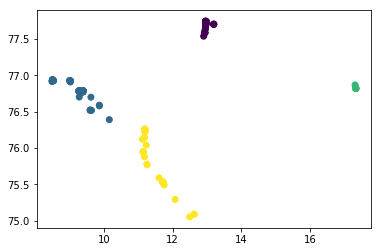

In [119]:
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.vq import kmeans2, whiten
x, cluster_labels = kmeans2(np.radians(latlong).values.tolist(),max(cluster_labels)-1, iter = 50)
plt.scatter(latlong['Latitude'], latlong['Longitude'], c=cluster_labels)
plt.show()

Generating bounding box (Convex Hull)

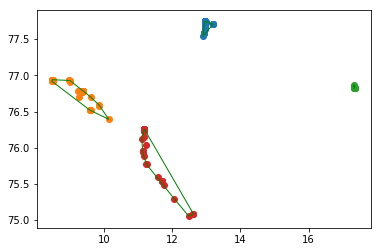

In [120]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
from scipy.spatial import ConvexHull
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)
    return poly


xcor=[]
ycor=[]
for i in range(max(cluster_labels)+1):
    xcor.append([])
    ycor.append([])
for i in range(max(cluster_labels)+1):
    for j in range(len(latlong)):
        if cluster_labels[j]==i:
            xcor[i].append(latlong.loc[j].values[0])
            ycor[i].append(latlong.loc[j].values[1])
            
for i in range(max(cluster_labels)+1):
    plt.scatter(xcor[i], ycor[i])

for i in range(max(cluster_labels)+1):
    if(len(xcor[i])>0):
        encircle(xcor[i], ycor[i], ec="green", fc="none")
plt.show()

In [121]:
import gmaps
def encircle(x,y):
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = p[hull.vertices,:]
    return poly
poly=[]
for i in range(max(cluster_labels)+1):
    if(len(xcor[i])>0):
        poly.append(encircle(xcor[i], ycor[i]).tolist())
drawing=[]
for i in range(len(poly)):
    drawing.append(gmaps.drawing_layer(features=[
         gmaps.Polygon(
             poly[i],
             fill_opacity=0,
             stroke_color='#000000',
             stroke_opacity=1
         )
    ]))

Generating layers for map

In [122]:
symbol_layers=[]

colors=['red','green',"blue","yellow","gray","black",'black','aqua', 'lime',"white"]
for i in range(max((cluster_labels))+1):
    cluster_locations=[]
    for j in range(len(cluster_labels)):
        if(cluster_labels[j]==i):
            cluster_locations.append(latlong.loc[j].values)
    symbol_layers.append(gmaps.symbol_layer(
            cluster_locations, fill_color=colors[i],scale=3,stroke_opacity=0))

Plotting on map


In [123]:
fig = gmaps.figure()
#fig.add_layer(gmaps.heatmap_layer(latlong, weights=np.ones(len(latlong), dtype = int) ))
for i in range(len(symbol_layers)):
    fig.add_layer(symbol_layers[i])

fig


Figure(layout=FigureLayout(height='420px'))

Plotting Heatmap

In [124]:
fig = gmaps.figure()
#fig.add_layer(gmaps.heatmap_layer(latlong, weights=np.ones(len(latlong), dtype = int) ))
fig.add_layer(gmaps.heatmap_layer(latlong, weights=None ))
for i in range(len(poly)):
    fig.add_layer(drawing[i])
fig


Figure(layout=FigureLayout(height='420px'))

# Finding the affected States & Districts and the level of impact

Working with shape files

In [13]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
#importing shapefiles
district_file = shp.Reader("2011_Census_Data/2011_Dist.shp")
state_file = shp.Reader("Indian_States/Indian_States.shp")

# Common for district and states

In [14]:
# intervals for confirmed cases (needed for color values)
state_interval=[0,50,200,1000,2000,3000,5000]
district_interval=[10,30,50,80,100,200,300]

In [15]:
def color_map(weight):
    return {
        1: (75, 143, 140),#Steel
        2: (0, 51, 0),#dark green
        3: (121, 184, 24),#light green
        4: (249, 220, 92),#light_yellow
        5: (243, 222, 10),#yellow
        6: (251, 97, 7),#vivid orange
        7: (230, 0, 0),
        8: (150, 2, 0),#dark red
    }.get(weight, (0,0,0))
def state_map_weights(total_cases):
    if(total_cases==state_interval[0]):
        return 1
    if(total_cases<=state_interval[1]):
        return 2
    if(total_cases<=state_interval[2]):
        return 3
    if(total_cases<=state_interval[3]):
        return 4
    if(total_cases<=state_interval[4]):
        return 5
    if(total_cases<=state_interval[5]):
        return 6
    if(total_cases<=state_interval[6]):
        return 7
    return 8 
def district_map_weights(total_cases):
    if(total_cases<=district_interval[0]):
        return 1
    if(total_cases<=district_interval[1]):
        return 2
    if(total_cases<=district_interval[2]):
        return 3
    if(total_cases<=district_interval[3]):
        return 4
    if(total_cases<=district_interval[4]):
        return 5
    if(total_cases<=district_interval[5]):
        return 6
    if(total_cases<=district_interval[6]):
        return 7
    return 8 
def zone_map_weights(place):
    zone=''
    if len(data_zones[data_zones['district']==place]['zone'].values)>0: #checking if place exists in covi19 dataset
        zone=str(data_zones[data_zones['district']==place]['zone'].values[0])
    else:
        key=[key  for (key, value) in district_mapping.items() if value == place] # else check in place_mapping
        data_lowercase=data_zones.copy()
        data_lowercase.index=data_zones['district'].str.lower()
        if(len(key)>0):
            zone=data_lowercase.loc[key[0]]['zone']
    if(zone=='Red'):
        return 7
    if(zone=='Orange'):
        return 6
    if(zone=='Green'):
        return 3
    else:
        print(place)
        return 1; #if place not found, return 1

In [36]:
#Function to return the number of total_cases,deceased and recovered patients of places (States/Districts) present mapping dictionary
#Parameters:
    #census_place: record of a row in the shapefile
    #place_mapping: Dictionary (either state_mapping or district_mapping
    #place_type: State/District
#Return Value: Total no. of cases,recovered and deceased.
def get_cases(census_place,place_mapping,type_place,data):
    recovered=0
    deceased=0
    key=[key  for (key, value) in place_mapping.items() if value == census_place] #set of keys which are in the place_mapping dictionary
    data_lowercase=data.copy()
    data_lowercase.index=data[type_place].str.lower()
    
    total_cases=sum(data_lowercase.loc[keys]['confirmed'] for keys in key if keys in data_lowercase.index)
    recovered=sum(data_lowercase.loc[keys]['confirmed']-data_lowercase.loc[keys]['deceased']-data_lowercase.loc[keys]['active'] for keys in key if keys in data_lowercase.index)
    deceased=sum(data_lowercase.loc[keys]['deceased'] for keys in key if keys in data_lowercase.index)
    
    return total_cases,recovered,deceased
#Function to return the number of deceased and recovered patients of places (States/Districts) present in covid19 dataset
#Parameters:
    #census_place: record of a row in the shapefile
    #place_type: State/District
#Return Value: Total no. of recovered and deceased.
def get_deceased_and_recovered(census_place,type_place,data):
    recovered=0
    deceased=0
    data_lowercase=data.copy()
    data_lowercase.index=data[type_place].str.lower()
    census_place=census_place.lower()
    if census_place in data_lowercase.index:
        patient_stats=data_lowercase.loc[census_place]
        recovered=patient_stats['recovered']
        deceased=patient_stats['deceased']
    return recovered,deceased
#Function: Extracts all the polygons from a given set of coordinates
#Paramters:
    #shape: single row of shapefile
#Return Values: list of coordinates. Each element of latlong_island -> Polygon
def extract_boundaries(shape):
    latlong=[]
    latlong_islands=[]
    l=np.array(shape.points[:])
    for j in range(len(l)):
        latlong.append([l[j,1],l[j,0]]) #Extracting all coordinates from the 'shape' variable
        
    index=0 #Signifying the starting index value of a polygon
    for k in range(1,len(latlong),1):
        if(latlong[index]==latlong[k] and index!=k): #signifies a polygon is completed (inital point = final point)
            latlong_islands.append(latlong[index:k+1])
            index=k+1 #index updated at the beginning of each polygon
    if(index<len(latlong)): # For the last polygon
        latlong_islands.append(latlong[index:len(latlong)])
    return latlong_islands

#Function: Generates the layers where each layer contains a polygon
#Paramters:
    #latlong_islands: Sets of coordinates (each element of latlong_islands signifying one polygon)
    #weight: Set of weights determining intensity of cases'
#Return Values: Set of Layer to be added to gmaps.figure(). No. of layers-> No. of polygons

def add_layers(latlong_islands,total_cases,place,type_place):
    layer=[]
    if(type_place=='district'):
        weight=district_map_weights(total_cases)
    elif(type_place=='district zones'):
        weight=zone_map_weights(place)
    else:
        weight=state_map_weights(total_cases)
    for k in range(len(latlong_islands)-1): #Adding each polygon as a layer except last
        layer.append(gmaps.drawing_layer(features=[
        gmaps.Polygon(
             latlong_islands[k],
             fill_opacity=0.8,
             stroke_color='#000000',
             fill_color=color_map(weight), 
             stroke_opacity=1, 
            stroke_weight=0.5,
         )
        ]))
    return layer
#Function: Generates the layer containing polygon as well as symbol layer (required for infobox)
#Paramters:
    #latlong_islands: Sets of coordinates (each element of latlong_islands signifying one polygon)
    #weight: Set of weights determining intensity of cases'
    #center: Center of polygon for on_click button
    #place: District or State
    #total_cases: Total no. of cases in the place (state/district) [String]
    #type_place: Takes two values: 'State' or 'District'
#Return Values: Single Layer to be added to gmaps.figure()

def add_layers_with_symbol(latlong_islands,center,place,total_cases,recovered,deceased,type_place):
    layer=[] #Adding the single layer
    details=type_place+": "+place+"</br>"+"No. of Cases: "+str(total_cases)+"</br>"+"Recovered: "+str(recovered)+"</br>"+"Deceased: "+str(deceased)
    if(type_place=='district'):
        weight=district_map_weights(total_cases)
    elif(type_place=='district zones'):
        weight=zone_map_weights(place)
        details='district: '+place
    else:
        weight=state_map_weights(total_cases)#(44,54,94)
    layer.append(gmaps.drawing_layer(features=[
    gmaps.Symbol(center,fill_color=color_map(weight),scale=2,fill_opacity=0.8,stroke_opacity=0.4,stroke_weight=0.5, info_box_content=details),
     gmaps.Polygon(
         latlong_islands,
         fill_opacity=0.8,
         stroke_color='#000000',
         fill_color=color_map(weight),
         stroke_opacity=1,
         stroke_weight=0.5,
     )
    ]))
    return layer
def get_legend(interval,type_of_legend=None):
    legend_template = '<span style="color: {color};opacity:{weight}; font-size: 2em; vertical-align: bottom;">&#9679;</span> {var}'
    legend_entries=[]
    if(type_of_legend=='zones'):
        new_values=[3,6,7]
        for i in range(len(interval)):
            legend_entries.append(legend_template.format(color="rgb"+str(color_map(new_values[i])), weight=0.8,var=interval[i]))
    else:
        for i in range(len(interval)):
            legend_entries.append(legend_template.format(color="rgb"+str(color_map(i+1)), weight=0.8,var=interval[i]))
    legend = widgets.HBox(
        [widgets.HTML(legend_entry) for legend_entry in legend_entries],
        layout=widgets.Layout(width='100%', justify_content='space-between')
    )
    return legend
def catch_error(total_cases,recovered,deceased):
    try:
        recovered=int(recovered)
    except:
        recovered=max(recovered)
    try:
        deceased=int(deceased)
    except:
        deceased=max(deceased)
    try:
        total_cases=int(total_cases)
    except:
        total_cases=max(total_cases)
    return total_cases,recovered,deceased

# Districts

In [19]:
# Maps corona dataset districts to census data district
district_mapping = {
    # new covid : old 2011
    'Paschim Medinipur':'Pashchim Medinipur',
    'West Singhbhum':'Pashchimi Singhbhum',
    'East Singhbhum':'Purbi Singhbhum',
    'Purulia':'Puruliya',
    'Ribhoi':'Ri Bhoi',
    'Saraikela-Kharsawan':'Saraikela-kharsawan',
    'Shivamogga':'Shimoga',
    'Siddharthnagar':'Siddharth Nagar',
    'Dang':'The Dangs',
    'Nilgiris':'The Nilgiris',
    'Sabarkantha':'Sabar Kantha',
    'Narsinghpur':'Narsimhapur',
    'Malda':'Maldah',
    'Mehsana':'Mahesana',
    'Lawngtlai':'Lawangtlai',
    'Lahaul and Spiti':'Lahul and Spiti',
    'Koderma':'Kodarma',
    'Cooch Behar':'Koch Bihar',
    'Lakhimpur Kheri':'Kheri',
    'Kanyakumari':'Kanniyakumari',
    'Kaimur':'Kaimur (bhabua)',
    'Janjgir Champa':'Janjgir-champa',
    'Jalore':'Jalor',
    'Jajpur':'Jajapur',
    'East Jaintia Hills':'Jaintia Hills',
    'West Jaintia Hills':'Jaintia Hills',
    'Jagatsinghpur':'Jagatsinghapur',
    'Gondia':'Gondiya',
    'Gadchiroli':'Garhchiroli',
    'Ferozepur':'Firozpur',
    'Ayodhya':'Faizabad',
    'Upper Dibang Valley':'Dibang Valley',
    'Lower Dibang Valley':'Dibang Valley',
    'Dholpur':'Dhaulpur',
    'Deoghar':'Debagarh',
    'Deogarh':'Debagarh',
    'Chittorgarh':'Chittaurgarh',
    'Chikkamagaluru':'Chikmagalur',
    'Chamarajanagara':'Chamrajnagar',
    'Buldhana':'Buldana',
    'Boudh':'Bauda',
    'Beed':'Bid',
    'Barabanki':'Bara Banki',
    'Bandipora':'Bandipore',
    'Banaskantha':'Banas Kantha',
    'Balasore':'Baleshwar',
    'Budgam':'Badgam',
    'Angul':'Anugul',
    'Chengalpattu':'Kancheepuram',
    'Ranipet': 'Kancheepuram',
    'Pauri Garhwal': 'Garhwal' ,
    'Bhadradri Kothagudem': 'Khammam',
    'South Salmara Mankachar': 'Dhubri',
    'Nuh': 'Mewat',
    'Kalaburagi':'Gulbarga',
    'Saran': 'Saran (chhapra)',
    'Gir Somnath': 'Junagadh',
    'S.P.S. Nellore': 'Sri Potti Sriramulu Nellore',
    'S.A.S. Nagar': 'Sahibzada Ajit Singh Nagar',
    'Virudhunagar': 'Virudunagar',
    'Medchal Malkajgiri': 'Malkangiri',
    'Bagalkote':'Bagalkot',
    'Belagavi':'Belgaum',
    'Ballari': 'Bellary',
    'Tirupathur': 'Tiruppur',
    'Ranga Reddy':'Rangareddy',
    'Jhunjhunu':'Jhunjhunun',
    'Tumakuru': 'Tumkur',
    'Morigaon':'Marigaon',
    'Hooghly':'Hugli',
    'Howrah':'Haora',
    'Gurugram':'Gurgaon',
    'Haridwar':'Hardwar',
    'Bengaluru Urban': 'Bangalore',
    'Bengaluru Rural':'Bangalore Rural',
    'Nagapattinam':'Nagappattinam',
    'West Champaran':'Pashchim Champaran',
    'East Champaran':'Purba Champaran',
    'Kalimpong':'Darjiling',
    'Mysuru':'Mysore',
    'Leh':'Leh (ladakh)',
    "Y.S.R. Kadapa":'Y.s.r.',
    'Chhota Udaipur':'Vadodara',
    'Hathras':'Aligarh',
    'Hathras':'Mahamaya Nagar',
    'Hapur':'Ghaziabad',
    'Sangareddy':'Medak',
    'Warangal Urban':'Warangal',
    'Khargone':'West Nimar',
    'Nirmal':'Adilabad',
    'Morbi':'Rajkot',
    'Shamli':'Muzaffarnagar',
    'Kallakurichi':'Viluppuram',
    'Pathankot':'Gurdaspur',
    'Peddapalli':'Karimnagar',
    'Vikarabad':'Rangareddy',
    'Gomati':'South Tripura',
    'Prayagraj':'Allahabad',
    'Charkhi Dadri':'Bhiwani',
    'Maharajganj':'Maharajganj',
    'Jagtial':'Karimnagar',
    'Mahabubnagar':'Mahbubnagar',
    'Narayanpet':'Mahbubnagar',
    'Jogulamba Gadwal':'Mahbubnagar',
    'Suryapet':'Nalgonda',
    'Khandwa':'East Nimar',
    'Dahod':'Dohad',
    'Tenkasi':'Tirunelveli',
    'Sri Muktsar Sahib':'Muktsar',
    'Amroha':'Jyotiba Phule Nagar',
    'Palghar':'Thane',
    'Bhadohi':'Sant Ravi Das Nagar(bhadohi)',
    'Botad':'Ahmadabad',
    'Jangaon':'Warangal',
    'Jayashankar Bhupalapally':'Warangal',
    'Kamareddy':'Nizamabad',
    'Kasganj':'Kansiram Nagar',
    'Kumuram Bheem Asifabad':'Adilabad',
    'Komaram Bheem':'Adilabad',
    'Mancherial':'Adilabad',
    'Mahabubabad':'Warangal',
    'Mulugu':'Warangal',
    'Nagarkurnool':'Mahbubnagar',
    'Rajanna Sircilla':'Karimnagar',
    'Sambhal':'Moradabad',
    'Siddipet':'Medak',
    'Vijayapura':'Belgaum',
    'Agar Malwa':'Shajapur',
    'Aravalli':'Sabar Kantha',
    'Mahisagar':'Panch Mahals',
    "Kutch":"Kachchh",
    'Nicobars':'Nicobar',
    'West District':'West Sikkim',
    'East District':'East Sikkim',
    'North District':'North Sikkim',
    'South District':'South Sikkim',
    'Shopiyan':"Shupiyan",
    'Baramulla':'Baramula',
    'Ahmednagar':'Ahmadnagar',
    'Paschim Bardhaman':'Barddhaman',
    'Purba Bardhaman':'Barddhaman',
    'Raigad':'Raigarh',
    'Darjeeling':'Darjiling',
    'Surajpur':'Surguja',
    'Ahmedabad':'Ahmadabad',
    'Devbhumi Dwarka':'Jamnagar',
    'Panchmahal':'Panch Mahals',
    'Fazilka':'Firozpur',
    'South East Delhi':'South Delhi',
    'Shahdara':'North East Delhi',
    '':''
   
}


district_mapping={k.lower(): v for k, v in district_mapping.items()}

To check if update is required to the dictionary (optional)

In [130]:
districts=list(data_district_wise["district"])
for i in range(len(districts)):
    flag=0
    for shape in district_file.shapeRecords():
        if("&" in shape.record[0]): # for e.g J & K converted to J and K
            shape.record[0]=shape.record[0].replace("&","and")
        if(shape.record[0] in ['East','West','North','South','North West','North East','South West','Central']):
            shape.record[0]=shape.record[0]+" "+shape.record[1].split(" ")[-1]
        if(shape.record[0].lower()==districts[i].lower() or (districts[i].lower() in district_mapping.keys() and shape.record[0].lower()==district_mapping[districts[i].lower()].lower())):
            flag=1
            break
    #List of districts not found in the updated covid19 dataset
    if(flag==0):
        print(districts[i])
        

Other State
Italians
Other States
Other Region
Evacuees
Italians
Other state
Other State
Unknown
Other State
Unknown
Unknown
Other State


Generating layers for all districts

In [37]:
districts=list(data_district_wise["district"])
district_layer=[]
for shape in district_file.shapeRecords(): #iterating through the census shapefile
    total_cases=0
    recovered=0
    deceased=0
    if("&" in shape.record[0]): # for e.g J & K converted to J and K
        shape.record[0]=shape.record[0].replace("&","and")
    if(shape.record[0] in ['East','West','North','South','North West','North East','South West','Central']):
        shape.record[0]=shape.record[0]+" "+shape.record[1].split(" ")[-1]
    
    # If district name exists in district_mappping dictionary we assign no. of total_cases to 'total_cases'           
    if shape.record[0] in district_mapping.values():
        total_cases,recovered,deceased=get_cases(shape.record[0],district_mapping,"district",data_district_wise)

        
    # if district name exists in covid19 dataset we assign no. of total_cases to 'total_cases'
    if shape.record[0] in districts:
        total_cases=total_cases+int(max(data_district_wise[data_district_wise["district"]==shape.record[0]]['confirmed']))
        a,b=get_deceased_and_recovered(shape.record[0],"district",data_district_wise)
        recovered+=a
        deceased+=b
        
    total_cases,recovered,deceased=catch_error(total_cases,recovered,deceased)
    if(total_cases==0):
        continue
        
    latlong_islands=extract_boundaries(shape.shape)
    district_layer.extend(add_layers(latlong_islands,total_cases,shape.record[0],"district"))
        
     # Appending the final Layer and adding a symbol_on_click service with it
    center=[(min(np.array(shape.shape.points[:])[:,1])+max(np.array(shape.shape.points[:])[:,1]))/2,(min(np.array(shape.shape.points[:])[:,0])+max(np.array(shape.shape.points[:])[:,0]))/2]
    district_layer.extend(add_layers_with_symbol(latlong_islands[-1],center,shape.record[0],total_cases,recovered,deceased,"district"))
            

        
    

Plotting on map

In [38]:
fig = gmaps.figure(center=(23.2599, 77.4126), zoom_level=4,display_toolbar=False,)
for i in range(len(district_layer)):
    fig.add_layer(district_layer[i])
interval=["Less than "+str(district_interval[0]),"Less than "+str(district_interval[1]),"Less than "+str(district_interval[2]),"Less than "+str(district_interval[3]),"Less than "+str(district_interval[4]),"Less than "+str(district_interval[5]),"Less than "+str(district_interval[6]),"Greater than "+str(district_interval[6])]
legend=get_legend(interval)
widgets.VBox([fig, legend])


# States

In [39]:
# Maps corona dataset states to census data states
state_mapping = {
    # new covid : old 2011
    'Jammu and Kashmir' :'Jammu & Kashmir',
    'Ladakh' :'Jammu & Kashmir',
    'Delhi': 'NCT of Delhi',
    'Arunachal Pradesh' :'Arunanchal Pradesh' ,
    'Andaman and Nicobar Islands': 'Andaman & Nicobar Island',
    'Dadra and Nagar Haveli':'Dadara & Nagar Havelli',
    'Daman and Diu':'Daman & Diu',
    '': '',
   
}
state_mapping={k.lower(): v for k, v in state_mapping.items()}

To check if update is required to the dictionary (optional)

In [134]:
states= list(data_death_and_recovered['state'])
for i in range(len(states)):
    flag=0
    for shape in state_file.shapeRecords():
        if(shape.record[0].lower()==states[i].lower() or (states[i].lower() in state_mapping.keys() and shape.record[0].lower()==state_mapping[states[i].lower()].lower())):
            flag=1
            break
    #List of states not found in the updated covid19 dataset
    if(flag==0):
        print(states[i])

Total


Generating layers for all states

In [40]:
states_affected = data.groupby(["detectedstate"]).size()
states=np.array(states_affected.keys())
states_layer=[]
for shape in state_file.shapeRecords():
    total_cases=0
    recovered=0
    deceased=0
    # If state name exists in state_mappping dictionary we assign no. of total_cases to 'total_cases'            
    if shape.record[0] in state_mapping.values():
        total_cases,recovered,deceased=get_cases(shape.record[0],state_mapping,"state",data_death_and_recovered)
        
    # if state name exists in covid19 dataset we assign no. of total_cases to 'total_cases'   
    elif shape.record[0] in states:
        total_cases=data.groupby("detectedstate").size()[shape.record[0]]
        recovered,deceased=get_deceased_and_recovered(shape.record[0],"state",data_death_and_recovered)
    
    latlong_islands=extract_boundaries(shape.shape)
    states_layer.extend(add_layers(latlong_islands,total_cases,shape.record[0],"state"))

     # Appending the final Layer and adding a symbol_on_click service with it
    center=[(min(np.array(shape.shape.points[:])[:,1])+max(np.array(shape.shape.points[:])[:,1]))/2,(min(np.array(shape.shape.points[:])[:,0])+max(np.array(shape.shape.points[:])[:,0]))/2]
    if(shape.record[0]=='Puducherry'): #Includes certain colonies in Maharashtra as well which creates problems while selecting infobox position
        center=[(min(np.array(latlong_islands[4])[:,0])+max(np.array(latlong_islands[4])[:,0]))/2,(min(np.array(latlong_islands[4])[:,1])+max(np.array(latlong_islands[4])[:,1]))/2]
    if(shape.record[0]=='Daman & Diu'):
         center=[(min(np.array(latlong_islands[0])[:,0])+max(np.array(latlong_islands[0])[:,0]))/2,(min(np.array(latlong_islands[0])[:,1])+max(np.array(latlong_islands[0])[:,1]))/2]
    states_layer.extend(add_layers_with_symbol(latlong_islands[-1],center,shape.record[0],total_cases,recovered,deceased,"state"))
            


Plotting on map

In [41]:
fig = gmaps.figure(center=(23.2599, 77.4126), zoom_level=4,display_toolbar=False)
for i in range(len(states_layer)):
    fig.add_layer(states_layer[i])
interval=["No cases "+str(state_interval[0]),"Less than "+str(state_interval[1]),"Less than "+str(state_interval[2]),"Less than "+str(state_interval[3]),"Less than "+str(state_interval[4]),"Less than "+str(state_interval[5]),"Less than "+str(state_interval[6]),"Greater than "+str(state_interval[6])]
legend=get_legend(interval)
widgets.VBox([fig, legend])

# Zones

In [42]:
districts=list(data_zones["district"])
zone_layer=[]
for shape in district_file.shapeRecords(): #iterating through the census shapefile

    #print(shape.record[0])
    total_cases=0
    recovered=0
    deceased=0
    #print(shape.record[0])
    if("&" in shape.record[0]): # for e.g J & K converted to J and K
        shape.record[0]=shape.record[0].replace("&","and")
    if(shape.record[0] in ['East','West','North','South','North West','North East','South East','South West','Central']):
        shape.record[0]=shape.record[0]+" "+shape.record[1].split(" ")[-1]
        
    latlong_islands=extract_boundaries(shape.shape)
    zone_layer.extend(add_layers(latlong_islands,total_cases,shape.record[0],"district zones"))
        
     # Appending the final Layer and adding a symbol_on_click service with it
    center=[(min(np.array(shape.shape.points[:])[:,1])+max(np.array(shape.shape.points[:])[:,1]))/2,(min(np.array(shape.shape.points[:])[:,0])+max(np.array(shape.shape.points[:])[:,0]))/2]
    zone_layer.extend(add_layers_with_symbol(latlong_islands[-1],center,shape.record[0],total_cases,recovered,deceased,"district zones")) 
            

        
    

Data Not Available
Data Not Available


In [43]:
fig = gmaps.figure(center=(23.2599, 77.4126), zoom_level=4,display_toolbar=False,)
for i in range(len(zone_layer)):
    fig.add_layer(zone_layer[i])
interval=["Green Zone","Orange Zone","Red Zone"]
legend=get_legend(interval,"zones")
widgets.VBox([fig, legend])
